In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projects/LPD

Mounted at /content/drive
/content/drive/MyDrive/Projects/LPD


In [ ]:
!pip install opendatasets

In [ ]:
import os
import opendatasets as od
if not os.path.isdir("car-plate-detection"):
  od.download("https://www.kaggle.com/datasets/andrewmvd/car-plate-detection")

EDA:

In [ ]:
from glob import glob

images=glob("car-plate-detection/images/*.png")
labels=glob("car-plate-detection/annotations/*.xml")


print(len(images),len(labels))

433 433


In [ ]:
from sklearn.model_selection import train_test_split

train_images,val_images,train_labels,val_labels=train_test_split(images,labels,test_size=0.2,random_state=42)

print(len(train_images),len(val_images),len(train_labels),len(val_labels))

346 87 346 87


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

def convert_files(images, annotations, folder):
    # Define YOLOv8 format folder structure: dataset/train or dataset/val
    images_folder = os.path.join(folder, "images")
    annotations_folder = os.path.join(folder, "labels")

    # Create folders if they don't exist
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(annotations_folder, exist_ok=True)

    # Loop over each annotation and corresponding image
    for img_path, ann_path in zip(images, annotations):
        # Extract the base file name (without extension)
        file_name = os.path.basename(img_path).split('.')[0]

        # Copy the image to the target folder (train/val in YOLOv8 format)
        shutil.copy(img_path, os.path.join(images_folder, os.path.basename(img_path)))

        # Parse the XML file for annotation
        tree = ET.parse(ann_path)
        root = tree.getroot()
        width=int(root.find("size").find("width").text)
        height=int(root.find("size").find("height").text)



        # Prepare the output path for the converted annotation file (YOLO format .txt)
        txt_output_path = os.path.join(annotations_folder, f"{file_name}.txt")

        # Open the .txt file to write the converted annotations
        with open(txt_output_path, "w") as f:
            # Loop through each object in the XML file
            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                class_name = 0
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)


                xcenter = (xmin + xmax) / (2 * width)
                ycenter = (ymin + ymax) / (2 * height)
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                # Write in YOLO format: class_name xmin ymin xmax ymax (adjust class_name as needed)
                f.write(f"{class_name} {xcenter} {ycenter} {w} {h}\n")

        print(f"Processed {file_name}: Image and annotation moved to {folder}")


In [ ]:
train_folder = "car-plate-detection/train"

convert_files(train_images, train_labels, train_folder)



val_folder = "car-plate-detection/val"

convert_files(val_images, val_labels, val_folder)


Processed Cars217: Image and annotation moved to car-plate-detection/train
Processed Cars417: Image and annotation moved to car-plate-detection/train
Processed Cars126: Image and annotation moved to car-plate-detection/train
Processed Cars174: Image and annotation moved to car-plate-detection/train
Processed Cars366: Image and annotation moved to car-plate-detection/train
Processed Cars342: Image and annotation moved to car-plate-detection/train
Processed Cars304: Image and annotation moved to car-plate-detection/train
Processed Cars87: Image and annotation moved to car-plate-detection/train
Processed Cars370: Image and annotation moved to car-plate-detection/train
Processed Cars289: Image and annotation moved to car-plate-detection/train
Processed Cars247: Image and annotation moved to car-plate-detection/train
Processed Cars102: Image and annotation moved to car-plate-detection/train
Processed Cars139: Image and annotation moved to car-plate-detection/train
Processed Cars420: Image a

In [ ]:
print(len(os.listdir("car-plate-detection/train/images")))
print(len(os.listdir("car-plate-detection/val/images")))

346
87


In [ ]:
import yaml
import os

# Define your paths and class names
train_folder = "/content/drive/MyDrive/Projects/LPD/car-plate-detection/train/images"
val_folder = "/content/drive/MyDrive/Projects/LPD/car-plate-detection/val/images"
class_names = ["license"]  # List of class names

# Define the YAML structure
data = {
    'train': os.path.abspath(train_folder),  # Absolute path to train images
    'val': os.path.abspath(val_folder),      # Absolute path to val images
    'nc': len(class_names),                  # Number of classes
    'names': class_names                     # List of class names
}

# Write the YAML file to a specific location
yaml_file_path = '/content/drive/MyDrive/Projects/LPD/data.yaml'
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file created successfully at '{yaml_file_path}'")


YAML file created successfully at '/content/drive/MyDrive/Projects/LPD/data.yaml'


## Yolov8

In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [ ]:
model.train(
    data='data.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=8,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Projects/LPD/car-plate-detection/train/labels... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:07<00:00, 47.66it/s]


train: New cache created: /content/drive/MyDrive/Projects/LPD/car-plate-detection/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 346/346 [00:06<00:00, 54.72it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Projects/LPD/car-plate-detection/val/labels... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 115.50it/s]


val: New cache created: /content/drive/MyDrive/Projects/LPD/car-plate-detection/val/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 87/87 [00:01<00:00, 45.23it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.419G      1.602      2.497      1.271          7        320: 100%|██████████| 44/44 [00:06<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all         87         94     0.0136      0.851      0.197     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.352G      1.539      1.519      1.198          5        320: 100%|██████████| 44/44 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.04it/s]

                   all         87         94      0.835      0.215      0.539      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.352G      1.479      1.304      1.208          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]

                   all         87         94      0.668      0.702      0.647      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      0.35G      1.545      1.316      1.193          8        320: 100%|██████████| 44/44 [00:04<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.07it/s]

                   all         87         94      0.775      0.697      0.758      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      0.35G      1.443      1.199      1.185          2        320: 100%|██████████| 44/44 [00:05<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]

                   all         87         94      0.854      0.649      0.742      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      0.35G      1.401      1.162      1.181          7        320: 100%|██████████| 44/44 [00:03<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.40it/s]

                   all         87         94      0.841      0.745      0.845       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.352G      1.388      1.151      1.152          4        320: 100%|██████████| 44/44 [00:04<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.58it/s]


                   all         87         94      0.865      0.748      0.748      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      0.35G      1.379      1.085      1.188          4        320: 100%|██████████| 44/44 [00:05<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.24it/s]

                   all         87         94      0.883      0.723      0.819      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.352G      1.346      1.024       1.18          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.15it/s]

                   all         87         94      0.832      0.791      0.837      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      0.35G       1.27     0.9895      1.137          6        320: 100%|██████████| 44/44 [00:04<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]

                   all         87         94      0.867      0.787      0.818      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.35G      1.293     0.8919      1.106          6        320: 100%|██████████| 44/44 [00:09<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]

                   all         87         94       0.88      0.787      0.829      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.35G      1.256     0.8729      1.102          4        320: 100%|██████████| 44/44 [00:03<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.49it/s]

                   all         87         94      0.837      0.777      0.781      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      0.35G      1.245     0.8709      1.107          3        320: 100%|██████████| 44/44 [00:05<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.85it/s]

                   all         87         94      0.858       0.84      0.857      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.352G      1.237     0.8746       1.08          2        320: 100%|██████████| 44/44 [00:04<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]

                   all         87         94      0.901      0.766       0.83      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.35G      1.177      0.851      1.088          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.87it/s]

                   all         87         94      0.884       0.83      0.857      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.352G      1.207      0.846      1.102          4        320: 100%|██████████| 44/44 [00:05<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.89it/s]

                   all         87         94      0.865       0.75      0.816      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.352G      1.139     0.7951      1.077          1        320: 100%|██████████| 44/44 [00:04<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.91it/s]

                   all         87         94      0.913       0.78      0.832      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.35G      1.158     0.8208      1.124          2        320: 100%|██████████| 44/44 [00:03<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]

                   all         87         94      0.948      0.782      0.828      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.35G      1.197     0.8031      1.093          2        320: 100%|██████████| 44/44 [00:05<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]

                   all         87         94      0.893      0.809       0.81      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      0.35G      1.188     0.8066      1.071          1        320: 100%|██████████| 44/44 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]

                   all         87         94      0.925      0.755      0.838      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      0.35G      1.198     0.7748      1.072          5        320: 100%|██████████| 44/44 [00:03<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.35it/s]

                   all         87         94      0.911      0.777      0.838      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      0.35G      1.128     0.7385      1.085          2        320: 100%|██████████| 44/44 [00:05<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]

                   all         87         94      0.911      0.713        0.8      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.352G       1.09     0.7479      1.037          4        320: 100%|██████████| 44/44 [00:04<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.70it/s]

                   all         87         94      0.897       0.84      0.864      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      0.35G      1.088     0.7366      1.039          4        320: 100%|██████████| 44/44 [00:03<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.50it/s]

                   all         87         94      0.867      0.835      0.838      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      0.35G      1.046     0.7059      1.034          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.97it/s]

                   all         87         94      0.903       0.84       0.85       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      0.35G      1.045     0.7004      1.035          4        320: 100%|██████████| 44/44 [00:04<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]

                   all         87         94       0.95      0.806      0.871      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      0.35G      1.011     0.6669      1.007          8        320: 100%|██████████| 44/44 [00:03<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.29it/s]

                   all         87         94       0.94      0.851      0.875      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.35G      1.035     0.6687      1.035          3        320: 100%|██████████| 44/44 [00:05<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all         87         94      0.959      0.777      0.864      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      0.35G     0.9839     0.6586      1.004          5        320: 100%|██████████| 44/44 [00:04<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.31it/s]

                   all         87         94      0.886      0.829      0.861      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.35G     0.9877     0.6395     0.9944          5        320: 100%|██████████| 44/44 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.08it/s]

                   all         87         94       0.95      0.814      0.871      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.352G      1.011     0.6513     0.9984          6        320: 100%|██████████| 44/44 [00:05<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]

                   all         87         94      0.899      0.798      0.856      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.352G     0.9643     0.6134     0.9888          2        320: 100%|██████████| 44/44 [00:04<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.53it/s]

                   all         87         94      0.892      0.795      0.844      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.352G      1.013     0.6375       1.03          1        320: 100%|██████████| 44/44 [00:03<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.70it/s]

                   all         87         94      0.932      0.809      0.868      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.35G     0.9608     0.6447     0.9949          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.86it/s]

                   all         87         94       0.92      0.787      0.852      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.35G     0.9493     0.6202     0.9999          5        320: 100%|██████████| 44/44 [00:04<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.12it/s]

                   all         87         94      0.906      0.851      0.872      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      0.35G     0.9679     0.6306     0.9821          2        320: 100%|██████████| 44/44 [00:04<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.77it/s]

                   all         87         94       0.87       0.83      0.877      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.352G     0.9707     0.6168     0.9994          4        320: 100%|██████████| 44/44 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.92it/s]


                   all         87         94       0.95      0.808      0.865      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      0.35G     0.9391     0.6024      1.013          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]

                   all         87         94       0.93      0.862      0.863      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      0.35G     0.9126      0.596     0.9933          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.91it/s]

                   all         87         94      0.883      0.806      0.824      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      0.35G     0.9235     0.5857      0.984          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all         87         94      0.916      0.807      0.873      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      0.35G     0.9486     0.6029     0.9992          8        320: 100%|██████████| 44/44 [00:04<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.95it/s]

                   all         87         94       0.93      0.848       0.88      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.35G     0.9525     0.6036     0.9967          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.10it/s]

                   all         87         94      0.942      0.867      0.897      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.352G     0.9111     0.5791     0.9695          4        320: 100%|██████████| 44/44 [00:05<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.97it/s]

                   all         87         94      0.929      0.862      0.893      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      0.35G     0.9224     0.5693     0.9775          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]

                   all         87         94      0.874       0.84       0.87      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.35G     0.9207     0.5735     0.9861          5        320: 100%|██████████| 44/44 [00:04<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.92it/s]

                   all         87         94      0.915       0.83      0.868      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.352G     0.9565     0.6014     0.9792          2        320: 100%|██████████| 44/44 [00:05<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.90it/s]

                   all         87         94      0.916       0.84      0.845      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      0.35G     0.9273     0.5842      0.982          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]

                   all         87         94      0.912      0.851      0.873      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      0.35G     0.8606     0.5666     0.9585          4        320: 100%|██████████| 44/44 [00:03<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.49it/s]

                   all         87         94      0.941      0.843      0.874      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.352G     0.9037     0.5778     0.9875          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.23it/s]

                   all         87         94      0.921      0.867      0.891      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.35G     0.8356     0.5419     0.9593          2        320: 100%|██████████| 44/44 [00:04<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.82it/s]

                   all         87         94      0.931      0.861      0.896      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.352G     0.9077     0.5495     0.9727          4        320: 100%|██████████| 44/44 [00:05<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.26it/s]

                   all         87         94      0.906       0.84      0.872      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      0.35G      0.852     0.5689     0.9461          7        320: 100%|██████████| 44/44 [00:07<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.62it/s]

                   all         87         94      0.918      0.862       0.88      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      0.35G     0.8613     0.5547     0.9657          5        320: 100%|██████████| 44/44 [00:04<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.65it/s]

                   all         87         94      0.899       0.85      0.866      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.352G     0.8486      0.541      0.969          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.04it/s]

                   all         87         94      0.951      0.883       0.89      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.35G     0.8457     0.5378     0.9564          3        320: 100%|██████████| 44/44 [00:05<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.21it/s]


                   all         87         94      0.918       0.84      0.848      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.352G      0.826     0.5401     0.9438          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.83it/s]

                   all         87         94      0.907      0.851      0.871      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.35G      0.844     0.5368     0.9488          5        320: 100%|██████████| 44/44 [00:03<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.63it/s]

                   all         87         94      0.898      0.862      0.889      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      0.35G     0.8221     0.5116     0.9639          4        320: 100%|██████████| 44/44 [00:06<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.54it/s]

                   all         87         94      0.928      0.817      0.855      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.35G      0.821     0.5212     0.9477          1        320: 100%|██████████| 44/44 [00:03<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]

                   all         87         94      0.933      0.798      0.853       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.35G       0.81     0.5284     0.9285          6        320: 100%|██████████| 44/44 [00:04<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.12it/s]

                   all         87         94      0.939      0.862       0.91      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.352G     0.7816     0.4975     0.9454          8        320: 100%|██████████| 44/44 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.90it/s]

                   all         87         94      0.945       0.83      0.876      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      0.35G     0.7725     0.4771     0.9357          2        320: 100%|██████████| 44/44 [00:03<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.11it/s]

                   all         87         94      0.961      0.819      0.881      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.35G     0.8066      0.516     0.9397          8        320: 100%|██████████| 44/44 [00:03<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]

                   all         87         94      0.912       0.83      0.868      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      0.35G     0.7988     0.5092     0.9502          5        320: 100%|██████████| 44/44 [00:06<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.81it/s]

                   all         87         94       0.89      0.857      0.878      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      0.35G     0.7845      0.499     0.9463          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]

                   all         87         94      0.894       0.83      0.875       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.35G     0.8444     0.5129     0.9695          4        320: 100%|██████████| 44/44 [00:03<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]

                   all         87         94      0.925       0.84      0.879      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.35G     0.7692     0.4787     0.9303          4        320: 100%|██████████| 44/44 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all         87         94      0.908      0.844       0.88      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      0.35G     0.7907     0.4869     0.9379          5        320: 100%|██████████| 44/44 [00:04<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]

                   all         87         94      0.898       0.84      0.887      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      0.35G     0.7841     0.4949       0.95          3        320: 100%|██████████| 44/44 [00:03<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.06it/s]

                   all         87         94      0.931      0.872      0.895      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      0.35G     0.7598     0.4938     0.9382          4        320: 100%|██████████| 44/44 [00:06<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         87         94      0.928      0.872      0.877      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.352G     0.7637      0.481     0.9251          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.54it/s]

                   all         87         94      0.932      0.875      0.889      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.35G     0.7479     0.4588     0.9423          3        320: 100%|██████████| 44/44 [00:04<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.61it/s]

                   all         87         94      0.901      0.851      0.883      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      0.35G      0.735     0.4676     0.9073          7        320: 100%|██████████| 44/44 [00:06<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.79it/s]

                   all         87         94      0.911      0.862      0.894       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      0.35G      0.733     0.4513     0.9252          5        320: 100%|██████████| 44/44 [00:04<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]

                   all         87         94      0.961      0.809       0.86      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.35G     0.7264     0.4558     0.9134          4        320: 100%|██████████| 44/44 [00:03<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.57it/s]

                   all         87         94      0.926       0.83      0.862      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.35G     0.7488     0.4686     0.9276          4        320: 100%|██████████| 44/44 [00:05<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]

                   all         87         94      0.963      0.823      0.868      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.35G     0.6705     0.4575     0.9183          7        320: 100%|██████████| 44/44 [00:04<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]

                   all         87         94      0.919      0.848      0.868      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.352G      0.705     0.4445     0.9253          5        320: 100%|██████████| 44/44 [00:04<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.02it/s]

                   all         87         94      0.929       0.84      0.869       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      0.35G      0.701     0.4415     0.9115          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.91it/s]

                   all         87         94      0.952      0.843       0.89      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      0.35G     0.7089     0.4515     0.9098          5        320: 100%|██████████| 44/44 [00:04<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.13it/s]

                   all         87         94      0.945      0.862      0.907      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.352G     0.7118     0.4575     0.9316          5        320: 100%|██████████| 44/44 [00:04<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.24it/s]

                   all         87         94      0.915       0.83      0.881      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.35G     0.6833     0.4418     0.8966          4        320: 100%|██████████| 44/44 [00:05<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all         87         94      0.909      0.883       0.91       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.35G     0.6856     0.4384     0.9177          6        320: 100%|██████████| 44/44 [00:04<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]

                   all         87         94      0.958      0.851        0.9      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      0.35G     0.6701      0.435     0.9007          6        320: 100%|██████████| 44/44 [00:04<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]

                   all         87         94      0.967      0.819      0.906      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      0.35G      0.695      0.437     0.9203          5        320: 100%|██████████| 44/44 [00:05<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.81it/s]

                   all         87         94      0.943      0.851      0.907      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      0.35G     0.7048     0.4352     0.9263          5        320: 100%|██████████| 44/44 [00:03<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.47it/s]

                   all         87         94       0.95       0.84      0.911       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.35G     0.6922     0.4333     0.9253          6        320: 100%|██████████| 44/44 [00:04<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.48it/s]

                   all         87         94      0.955       0.84      0.916      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.35G     0.6854     0.4248     0.9012          5        320: 100%|██████████| 44/44 [00:06<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.18it/s]

                   all         87         94      0.933      0.862      0.913      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.352G     0.7006     0.4256     0.9168          6        320: 100%|██████████| 44/44 [00:03<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.04it/s]

                   all         87         94      0.942      0.862      0.903      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.35G     0.6711     0.4093     0.8961          2        320: 100%|██████████| 44/44 [00:03<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.59it/s]


                   all         87         94      0.955      0.851      0.908      0.501
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      0.35G      1.111     0.5706      1.028          2        320: 100%|██████████| 44/44 [00:07<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.13it/s]

                   all         87         94      0.962      0.816      0.887      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      0.35G      1.069     0.5617      1.035          2        320: 100%|██████████| 44/44 [00:05<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         87         94      0.952      0.851      0.899      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      0.35G      1.054     0.5575      1.022          2        320: 100%|██████████| 44/44 [00:06<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]


                   all         87         94       0.94      0.851      0.886      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      0.35G      1.063     0.5379      1.024          2        320: 100%|██████████| 44/44 [00:04<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.57it/s]

                   all         87         94      0.958      0.862      0.896      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      0.35G      1.048     0.5239      1.007          2        320: 100%|██████████| 44/44 [00:03<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.98it/s]

                   all         87         94      0.942      0.869      0.888      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      0.35G      1.058     0.5436      1.017          2        320: 100%|██████████| 44/44 [00:05<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.94it/s]

                   all         87         94      0.932      0.872      0.898      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      0.35G     0.9958     0.5163     0.9979          2        320: 100%|██████████| 44/44 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.49it/s]

                   all         87         94      0.943      0.879      0.899      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      0.35G      1.017     0.4986     0.9955          2        320: 100%|██████████| 44/44 [00:03<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.75it/s]

                   all         87         94      0.954      0.881      0.903       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.35G      1.043     0.5057      1.013          2        320: 100%|██████████| 44/44 [00:05<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]


                   all         87         94      0.954      0.881      0.904      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      0.35G      1.019      0.507     0.9888          2        320: 100%|██████████| 44/44 [00:04<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]

                   all         87         94      0.942      0.869        0.9      0.512



100 epochs completed in 0.170 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


                   all         87         94      0.958      0.862      0.896      0.516
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f54e1386e60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

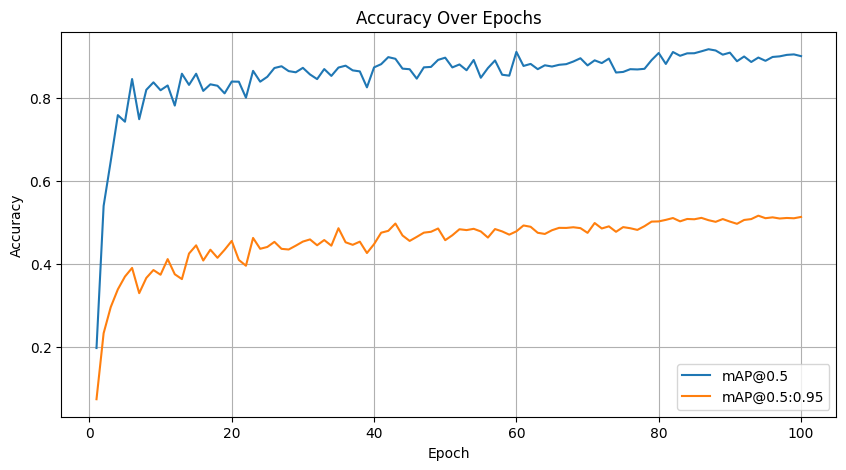

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the training results from the CSV file
results = pd.read_csv(os.path.join('runs/detect/train', 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('LPD.pt')

### Detection+OCR

In [22]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 16.5 MB/s eta 0:00:00


In [82]:
import cv2

def get_detections(image, model, reader):
    # Get YOLOv8 predictions
    results = model.predict(image, verbose=False)

    for result in results:
        for box in result.boxes:  # Iterate through each bounding box
            # Extract bounding box coordinates and class confidence
            x1, y1, x2, y2 = box.xyxy.cpu().numpy()[0]
            conf = box.conf.cpu().numpy()[0]
            cls = box.cls.cpu().numpy()[0]

            # Crop the detected area
            cropped_image = image[int(y1):int(y2), int(x1):int(x2)]

            # Perform OCR on the cropped image
            ocr_results = reader.readtext(cropped_image)

            # Iterate through OCR results (bbox, text, confidence)
            for ocr_result in ocr_results:
                bbox, text, confidence = ocr_result

                # Draw the bounding box from YOLO detection
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

                # Draw OCR results on the original image
                # Calculate the size of the text for the background rectangle
                text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                text_width, text_height = text_size

                # Draw a background rectangle for the OCR text
                cv2.rectangle(image,
                              (int(x1), int(y1) - text_height - 10),  # Background top-left
                              (int(x1) + text_width + 10, int(y1)),   # Background bottom-right
                              (0, 0, 255), -1)  # Red background

                # Put the text on top of the background
                cv2.putText(image,
                            text,
                            (int(x1) + 5, int(y1) - 5),  # Slight padding inside the box
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (255, 255, 255), 2)  # White text



(-0.5, 499.5, 267.5, -0.5)

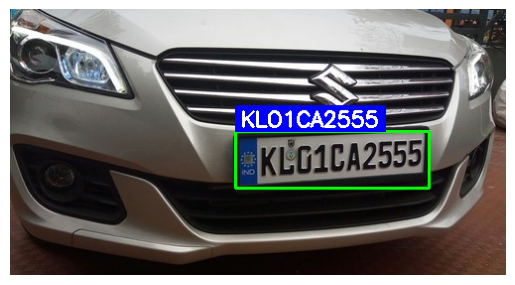

In [85]:
import cv2
import easyocr
from ultralytics import YOLO



image=cv2.imread('car-plate-detection/val/images/Cars0.png')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


model	= YOLO('LPD.pt')
reader = easyocr.Reader(['en'])

get_detections(image,model,reader)
plt.imshow(image)
plt.axis('off')